### Text Classification using `BiRNN`
This notebook is just an expantion of the previous notebook. In this notebook we are going to apply `RNN` layers instead of `Conv1D` layers as we did in the last notebook. The reason being that RNN are better in processing sequencial data which is our case.

The reast of the notebook will remain the same as the previous notebook, where there's, we are only going to change few things.

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import os, random, string, re

from tensorflow.keras.layers import TextVectorization

np.__version__

'1.19.5'

### Data
We are going to download the data (IMDB) dataset and load in google colab.

To download the data we are going to use the following command:

```shell
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

# extracting
!tar -xf aclImdb_v1.tar.gz
```

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.6M      0  0:00:05  0:00:05 --:--:-- 18.3M


The `aclImdb/train/pos` and `aclImdb/train/neg` folders contain text files, each of which represents one review (either `positive` or `negative`):

Let's check a single example of a positive review using the shell command `cat`.

In [3]:
!cat aclImdb/train/pos/6248_7.txt

Being an Austrian myself this has been a straight knock in my face. Fortunately I don't live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!". No, not with me, the (in my opinion) totally exaggerated uncensored swinger club scene is not necessary, I watch porn, sure, but in this context I was rather disgusted than put in the right context.<br /><br />This movie tells a story about how misled people who suffer from lack of education or bad company try to survive and live in a world of redundancy and boring horizons. A girl who is treated like a whore by her super-jealous boyfriend (and still keeps coming back), a female teacher who discovers her masochism by putting the life of her super-cruel "lover" 

We are only interested in the `pos` and `neg` folders, so let's delete the other files

In [4]:
!rm -r aclImdb/train/unsup
!rm -r aclImdb/test/unsup

rm: cannot remove 'aclImdb/test/unsup': No such file or directory


Now our folder and file structures looks as follows:

```
📁 acllmdb
  📁 test
    📁 neg
      🗄...txt
    📁 pos
     🗄...txt
  📁 train
    📁 neg
     🗄...txt
    📁 pos
     🗄...txt
```

We are going to use the [`tf.keras.preprocessing.text_dataset_from_directory`](https://keras.io/api/preprocessing/text#textdatasetfromdirectory-function) to generate a labeled [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object from text files that are in our disk.

We are then going to generate three sets of data. The train, validation and test. The validation set will come as a fraction of `20%` from the train set.

### Loading the data using the `tf.keras.preprocessing.text_dataset_from_directory()`

In [5]:
!rm -r aclImdb/train/.ipynb_checkpoints
!rm -r aclImdb/test/.ipynb_checkpoints

rm: cannot remove 'aclImdb/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'aclImdb/test/.ipynb_checkpoints': No such file or directory


In [6]:
BATCH_SIZE = 128 # we are going to increase the batchsize this time around to 128 from 32
SEED = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = BATCH_SIZE,
    validation_split = .2,
    subset = "training",
    seed = SEED
)
raw_valid_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = BATCH_SIZE,
    validation_split = .2,
    subset = "validation",
    seed = SEED
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size = BATCH_SIZE
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Counting examples...

In [7]:
print("train examples: %d"
 % tf.data.experimental.cardinality(raw_train_ds))
print("test examples: %d"
 % tf.data.experimental.cardinality(raw_test_ds))
print("valid examples: %d"
 % tf.data.experimental.cardinality(raw_valid_ds))

train examples: 157
test examples: 196
valid examples: 40


Let's check a some examples in a single batch.

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for text, label in zip(text_batch, label_batch[:5]):
    print(f"text: {text}\nlabel: {label}\nn")

text: b"CAROL'S JOURNEY is a pleasure to watch for so many reasons. The acting of Clara Lago is simply amazing for someone so young, and she is one of those special actors who can say say much with facial expressions. Director Imanol Urbibe presents a tight and controlled film with no break in continuity, thereby propelling the plot at a steady pace with just enough suspense to keep one wondering what the nest scene will bring. The screenplay of Angel Garcia Roldan is story telling at its best, which, it seems, if the major purpose for films after all. The plot is unpredictable, yet the events as they unravel are completely logical. Perhaps the best feature of this film if to tell a story of the Spanish Civil War as it affected the people. It was a major event of the 20th century, yet hardly any Americans know of it. In fact, in 40 years of university teaching, I averaged about one student a semester who had even heard of it, much less any who could say anything comprehensive about it-

### Data cleaning
We are going to clean our data. By cleaning I mean removing unnessesarry text for example ``html`` tags. We are goiing to create a `standardization` function which will do the following:

1. lower case the text
2. remove html tags


In [9]:
def standardization(input_data):
  input_data = tf.strings.lower(input_data)
  input_data = tf.strings.regex_replace(input_data, "<br/>", " ")
  return tf.strings.regex_replace(
      input_data, re.escape(string.punctuation), ""
  )

### Model Hyper Params

In [10]:
MAX_FEATURES = 20000
EMBEDDING_DIM = 100
SEQUENCE_LENGTH = 500

### Text Vectorization
Now that we have our function that standadize text, we can then create a vectorization layer. WE are using this layer to:
1. split strings
2. map them to integer representations


In [11]:
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [12]:
vectorize_layer.get_vocabulary()

['', '[UNK]']

As you can see that we only have the ``''`` and ``[UNK]`` as our vocabulary, we need to to make our `vectorize_layer` to adapt to our train features. So to do that we need to extract text features first from our `train_dataset` and the we call the `adapt`method to create the vocabulary.

In [13]:
text_ds = raw_train_ds.map(lambda x, y: x)

In [14]:
vectorize_layer.adapt(text_ds)

### Text vectorization layer.

There are two options we can use to vectorize our data.

1. **Make it part of the model**

This method allows us to pass the raw text strings to the model and the model will take care of the rest for us: The following example shows how we can use this method:

```py
input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorized_layer(input)
x = keras.layers.Embedding(MAX_FEATURES + 1, EMBEDDING_DIM)(x)

....
```

2. **Apply it to the text dataset**.

This method will obtain a dataset of word indices then feed those to the network.

> An important difference between the two is that option 2 enables you to do **asynchronous CPU processing and buffering** of your data when training on GPU. So if you're training the model on GPU, you probably want to go with this option to get the best performance



In [15]:
def vectorize(text, label):
  text= tf.expand_dims(text, -1)
  return vectorize_layer(text), label

Vectorizing the data

In [16]:
train_ds = raw_train_ds.map(vectorize)
valid_ds = raw_valid_ds.map(vectorize)
test_ds = raw_test_ds.map(vectorize)

### Async prefetching / buffering of the data 

In [17]:
BUFFER_SIZE =  100
train_ds = train_ds.cache().prefetch(buffer_size=BUFFER_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=BUFFER_SIZE)
valid_ds = valid_ds.cache().prefetch(buffer_size=BUFFER_SIZE)

### Building the model


We are still going to make use of the functional API but this time around we will use the Bi-Direction RNN with LSTM layer as the forward layer and GRU as the backward layer.


In [18]:
forward_layer = keras.layers.GRU(128, return_sequences=True, dropout=.5)
backward_layer = keras.layers.LSTM(128, activation='tanh', return_sequences=True,
                       go_backwards=True, dropout=.5)
inputs = keras.layers.Input(shape=(None, ), dtype="int64")

x = keras.layers.Embedding(MAX_FEATURES,EMBEDDING_DIM)(inputs)
x = keras.layers.Dropout(rate=.5)(x)

x = keras.layers.Bidirectional(
    forward_layer,
    backward_layer = backward_layer
)(x)

x = keras.layers.GRU(
    128, return_sequences=True
)(x)
x = keras.layers.LSTM(
    128, return_sequences=True,
   dropout=.5
)(x)
# flatten_layer = keras.layers.Flatten(name="flatten_layer")(lstm_layer)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(rate=.5)(x)

outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs, name="rnn_model")

model.summary()


Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         205568    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         148224    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0 

### Ploting the mode'l

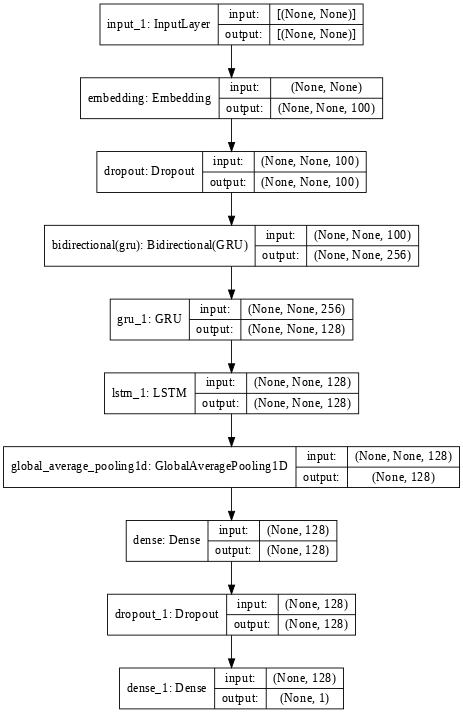

In [19]:
keras.utils.plot_model(model, dpi=64, show_shapes=True)

### Compiling the model

In [20]:
model.compile(loss="binary_crossentropy",
              optimizer="adam", 
              metrics=["accuracy"])

### Training the model

In [21]:
EPOCHS = 3

model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

Epoch 1/3
157/157 [==============================] - 88s 511ms/step - loss: 0.6072 - accuracy: 0.6284 - val_loss: 0.4197 - val_accuracy: 0.8170
Epoch 2/3
157/157 [==============================] - 78s 499ms/step - loss: 0.2953 - accuracy: 0.8816 - val_loss: 0.2995 - val_accuracy: 0.8798
Epoch 3/3
157/157 [==============================] - 79s 501ms/step - loss: 0.1971 - accuracy: 0.9255 - val_loss: 0.3866 - val_accuracy: 0.8652


### Evaluating the model

In [22]:
model.evaluate(test_ds,verbose=1)

196/196 [==============================] - 32s 160ms/step - loss: 0.3958 - accuracy: 0.8587


[0.3958146870136261, 0.858680009841919]

### Model inference

In the predict we are going to vectorize the text, then we are going to call the model.predict so that it will returns a prediction label to us.

In [23]:
data = []
for text_batch, label_batch in raw_test_ds.take(1):
  for text, label in zip(text_batch, label_batch[:5]):
    data.append({"text":text, "label": label})

In [24]:
def vectorize_text(text):
  text= tf.expand_dims(text, -1)
  return vectorize_layer(text)

vectorize_text("this movie sucks!")

<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[   10,    20, 18031,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [25]:
def make_prediction(text):
  vectors = vectorize_text(text)
  pred = tf.round(tf.squeeze(model(vectors)))
  return pred.numpy().astype("int32")

In [26]:
print("real label\tpredicted label\tpredicted class")
for ele in data:
  predicted = make_prediction(ele["text"])
  print(f"{predicted}\t\t{ele['label']}\t\t{raw_train_ds.class_names[predicted]}")

real label	predicted label	predicted class
0		0		neg
1		1		pos
0		0		neg
0		0		neg
1		1		pos


### Making an End-End Model.

We are going to then make an end to end RNN model that will be able to process strings.

In [27]:
forward_layer = keras.layers.GRU(128, return_sequences=True, dropout=.5)
backward_layer = keras.layers.LSTM(128, activation='tanh', return_sequences=True,
                       go_backwards=True, dropout=.5)
inputs = keras.layers.Input(shape=(1, ), dtype="string")
x = vectorize_layer(inputs)

x = keras.layers.Embedding(MAX_FEATURES,EMBEDDING_DIM)(x)
x = keras.layers.Dropout(rate=.5)(x)

x = keras.layers.Bidirectional(
    forward_layer,
    backward_layer = backward_layer
)(x)

x = keras.layers.GRU(
    128, return_sequences=True
)(x)
x = keras.layers.LSTM(
    128, return_sequences=True,
   dropout=.5
)(x)
# flatten_layer = keras.layers.Flatten(name="flatten_layer")(lstm_layer)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(rate=.5)(x)

outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs, name="rnn_model")

model.summary()

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          2000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 256)          205568    
_________________________________________________________________
gru_3 (GRU)                  (None, 500, 128)          148224    
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 128)          13

### Training the end-to-end model

In [28]:
model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

EPOCHS = 3

model.fit(raw_train_ds, validation_data=raw_valid_ds, epochs=EPOCHS)

Epoch 1/3
157/157 [==============================] - 89s 520ms/step - loss: 0.5962 - accuracy: 0.6336 - val_loss: 0.3420 - val_accuracy: 0.8600
Epoch 2/3
157/157 [==============================] - 81s 514ms/step - loss: 0.2742 - accuracy: 0.8887 - val_loss: 0.2984 - val_accuracy: 0.8854
Epoch 3/3
157/157 [==============================] - 80s 508ms/step - loss: 0.1986 - accuracy: 0.9247 - val_loss: 0.3189 - val_accuracy: 0.8814


### Evalutaing the model

In [29]:
model.evaluate(raw_test_ds,verbose=1)

196/196 [==============================] - 33s 169ms/step - loss: 0.3462 - accuracy: 0.8740


[0.346204936504364, 0.8740000128746033]

### Model Inference

In [30]:
def make_prediction(text):
  text = tf.constant(text, dtype="string")
  text= tf.expand_dims(text, -1)
  pred = tf.round(tf.squeeze(model(text)))
  return pred.numpy().astype("int32")

In [31]:
print("real label\tpredicted label\tpredicted class")
for ele in data:
  predicted = make_prediction(ele["text"])
  print(f"{predicted}\t\t{ele['label']}\t\t{raw_train_ds.class_names[predicted]}")

real label	predicted label	predicted class
0		0		neg
1		1		pos
0		0		neg
0		0		neg
1		1		pos
